# Format Dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
# Libraries
import os
import glob
import matplotlib.pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
from tqdm.notebook import tqdm as tqdm
import tensorflow as tf
import random
from pathlib import Path

from utils.tools import *
from utils.preprocess import *
from utils.visualize import *
from utils.data import *

[autoreload of google.protobuf.descriptor failed: Traceback (most recent call last):
  File "/home/simone/.virtualenvs/semseg/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/simone/.virtualenvs/semseg/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/simone/.virtualenvs/semseg/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/simone/.virtualenvs/semseg/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/home/simone/.virtualenvs/semseg/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 307, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to DescriptorMetaclass object
]
2023-07-24 18:05:22

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", physical_devices)

#select the working GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-24 18:05:25.107947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 18:05:25.117252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 18:05:25.117333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [9]:
## define dataset import paths
ROOT = Path('../AgriSeg_Dataset/misc/')
DATASETS = sorted([ROOT.joinpath(d) for d in os.listdir(ROOT)
                   if not d.startswith('.') and not d.endswith('.yaml')])

In [21]:
# define some variables and read config
config_path = 'utils/config.yaml'
model_dir = Path('bin')
logs_dir = Path('logs')
config = read_yaml(config_path)
config

{'GPU': [0],
 'SEED': 0,
 'VERBOSE': False,
 'NAME': 'ISW',
 'SAVE_BEST': True,
 'HP_SEARCH': False,
 'HP_SEARCH_NAME': 'kd_aug_rome',
 'HP_SEARCH_DIR': 'trials',
 'N_TRIALS': 12,
 'CITYSCAPES': False,
 'DG': True,
 'METHOD': 'ISW',
 'PADAIN': {'P': 0.001, 'EPS': '1e-5'},
 'UNISTYLE': True,
 'WHITEN_LAYERS': [-1, 0, 1],
 'TARGET': 'pear',
 'SOURCE': ['tree_2', 'chard', 'lettuce', 'vineyard'],
 'SUBSAMPLE': True,
 'STYLE_AUG': True,
 'RND_FLIP': 0.5,
 'RND_CROP': 0.5,
 'RND_GREY': 0.1,
 'RND_JITTER': 1.0,
 'RND_JITTER_RNG': 0.4,
 'DATA_PATH': 'datasets/',
 'MODEL_PATH': 'bin/',
 'LOG_PATH': 'logs/',
 'IMG_SIZE_TEST': [640, 480],
 'IMG_SIZE': 224,
 'SPLIT_SIZE': 0.1,
 'BATCH_SIZE': 64,
 'N_CLASSES': 1,
 'N_EPOCHS': 50,
 'LOSS': 'bce',
 'AUX_LOSS': False,
 'KD': {'ALPHA': 0.0001, 'T': 2},
 'CL': {'TEMP': 0.5, 'WEIGHT': 0.0},
 'OPTIMIZER': 'adamw',
 'SGD': {'LR': '1e-2', 'MOMENTUM': 0.8, 'DECAY': 0.1, 'NESTEROV': False},
 'ADAM': {'LR': '3e-4'},
 'ADAMW': {'LR': '5e-3', 'LR_END': '5e-6', '

In [22]:
DATASETS

[PosixPath('../AgriSeg_Dataset/misc/misc_1')]

In [25]:
D = DATASETS[0]

ROOT_I = D.joinpath('images')
ROOT_M = D.joinpath('masks')
try:
    os.mkdir(ROOT_I)
    os.mkdir(ROOT_M)
except:
    pass

LRM = sorted([str(ROOT_M.joinpath(f)) for f in os.listdir(ROOT_M) if f.startswith('image')])
LRI = sorted([str(ROOT_I.joinpath(f)) for f in os.listdir(ROOT_I) if f.startswith('image')])

In [26]:
len(LRI), len(LRM)

(100, 100)

In [18]:
def format_subdataset(D):
    ROOT_I = D.joinpath('images')
    ROOT_M = D.joinpath('masks')
    try:
        os.mkdir(ROOT_I)
        os.mkdir(ROOT_M)
    except:
        pass

    LRM = sorted([str(D.joinpath(f)) for f in os.listdir(ROOT_M) if f.startswith('img')])
    LRI = sorted([str(D.joinpath(f)) for f in os.listdir(ROOT_I) if f.startswith('img')])

    # LRM = sorted([str(D.joinpath(f).joinpath(os.listdir(D.joinpath(f))[2]))
    #               for f in os.listdir(D) if not f.endswith('.json')])
    # LRI = sorted([str(D.joinpath(f).joinpath(os.listdir(D.joinpath(f))[3]))
    #               for f in os.listdir(D)if not f.endswith('.json')])
    print(LRM)
    print(LRI)
    #move_files(l=LRM, root=ROOT_M)
    #move_files(l=LRI, root=ROOT_I)

In [28]:
D = DATASETS[0]
[str(D.joinpath(f).joinpath(os.listdir(D.joinpath(f))[0])) for f in os.listdir(D) if not f.endswith('.json') and not f.startswith('.')]

['../AgriSeg_Dataset/misc/misc_1/masks/image_78.png',
 '../AgriSeg_Dataset/misc/misc_1/images/image_45.jpg',
 '../AgriSeg_Dataset/misc/misc_1/embeddings/image_25.npy']

In [34]:
def move_files(l, root):
    for i, f in enumerate(sorted(l)):
        fname = f.split('/')[-1]
        print(fname)
        destf = root.joinpath(f'Image{i+1}')
        os.mkdir(destf)
        print(destf)
        os.replace(f, destf.joinpath(fname))
        print(f, destf.joinpath(fname))
        #break

In [36]:
move_files(l=LRI, root=ROOT_I)

image_1.jpg
../AgriSeg_Dataset/misc/misc_1/images/Image1
../AgriSeg_Dataset/misc/misc_1/images/image_1.jpg ../AgriSeg_Dataset/misc/misc_1/images/Image1/image_1.jpg
image_10.jpg
../AgriSeg_Dataset/misc/misc_1/images/Image2
../AgriSeg_Dataset/misc/misc_1/images/image_10.jpg ../AgriSeg_Dataset/misc/misc_1/images/Image2/image_10.jpg
image_100.png
../AgriSeg_Dataset/misc/misc_1/images/Image3
../AgriSeg_Dataset/misc/misc_1/images/image_100.png ../AgriSeg_Dataset/misc/misc_1/images/Image3/image_100.png
image_11.jpg
../AgriSeg_Dataset/misc/misc_1/images/Image4
../AgriSeg_Dataset/misc/misc_1/images/image_11.jpg ../AgriSeg_Dataset/misc/misc_1/images/Image4/image_11.jpg
image_12.jpg
../AgriSeg_Dataset/misc/misc_1/images/Image5
../AgriSeg_Dataset/misc/misc_1/images/image_12.jpg ../AgriSeg_Dataset/misc/misc_1/images/Image5/image_12.jpg
image_13.jpg
../AgriSeg_Dataset/misc/misc_1/images/Image6
../AgriSeg_Dataset/misc/misc_1/images/image_13.jpg ../AgriSeg_Dataset/misc/misc_1/images/Image6/image_13.jp

In [19]:
for d in DATASETS:
    format_subdataset(d)

['../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_0.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_1.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_10.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_100.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_101.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_102.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_103.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_104.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_105.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_106.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_107.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_108.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_109.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_11.png', '../AgriSeg_Dataset/vineyard_real/vineyard_real_1/img_110.png', '../AgriSeg_Dataset/vineyard_real/vineyard_re

In [ ]:
### DANGER ###

# for i in LRM+LRI:
#     os.remove(i)

# Display some Images

In [ ]:
import os 
from PIL import Image
from pathlib import Path

In [ ]:
def display_samples(dataset='zucchini', i=0, n=5, s=0.25):
    
    init = 'z' if dataset == 'zucchini' else 'd'
    
    ROOT = Path(f'Agrivol_datasets/dataset_{dataset}/')
    DATASETS = sorted([ROOT.joinpath(d) for d in os.listdir(ROOT) if d.startswith(init)])
    
    D = DATASETS[i]
    ROOT_I = D.joinpath('images')

    LRI = [str(ROOT_I.joinpath(f).joinpath(os.listdir(ROOT_I.joinpath(f))[0])) for f in os.listdir(ROOT_I)]
    
    for j in range(n):
        im = Image.open(LRI[j])
        display(im.resize((int(im.width*s),int(im.height*s))))

In [ ]:
display_samples('zucchini',i=0)

# Format Tree Dataset

In [ ]:
import os 
from PIL import Image
from pathlib import Path

In [ ]:
s = 0.5

ROOT_I = Path('datasets/dataset_vite/dataset_vite_1/images/')
ROOT_M = Path('datasets/dataset_vite/dataset_vite_1/masks/')
LRI = [str(ROOT_I.joinpath(f)) for f in os.listdir(ROOT_I)]
LRM = [str(ROOT_M.joinpath(f)) for f in os.listdir(ROOT_M)]
    
# for j in range(5):
#     im = Image.open(LRI[j])
#     #display(im.resize((int(im.width*s),int(im.height*s))))
#     im = np.array(im)
#     print(im.min(), im.max())
#     plt.imshow(im)
#     plt.show()

In [ ]:
sorted(LRM)

In [ ]:
for i, f in enumerate(sorted(LRI)):
    fname = f.split('/')[-1]
    #print(fname)
    destf = ROOT_I.joinpath(f'Image{i+1}')
    os.mkdir(destf)
    #print(destf)
    os.replace(f, destf.joinpath(fname))
    #print(f, destf.joinpath(fname))
    #break

In [ ]:
ROOT_I

In [ ]:
img_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=ROOT_I,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    #validation_split=0,
    #subset=train,
    interpolation="bilinear",
    follow_links=False)

# Load Datasets

In [64]:
ROOT_I = D.joinpath('images')
ROOT_M = D.joinpath('masks')

In [65]:
img_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=ROOT_I,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    #validation_split=0,
    #subset=train,
    interpolation="bilinear",
    follow_links=False)

Found 98 files belonging to 1 classes.


2023-06-08 15:28:32.331988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 15:28:32.332538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:28:32.332657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:28:32.332701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [66]:
mask_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=ROOT_M,
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=128,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    #validation_split=0,
    #subset=train,
    interpolation="bilinear",
    follow_links=False)

Found 95 files belonging to 1 classes.


In [43]:
if 'albero' in str(ROOT_M):
    mask_ds = mask_ds.map(binarize_mask)
else:
    mask_ds = mask_ds.map(normalize)

In [44]:
#img_ds = img_ds.map(lambda x: tf.keras.applications.imagenet_utils.preprocess_input(x, mode='torch'))

0.0 255.0


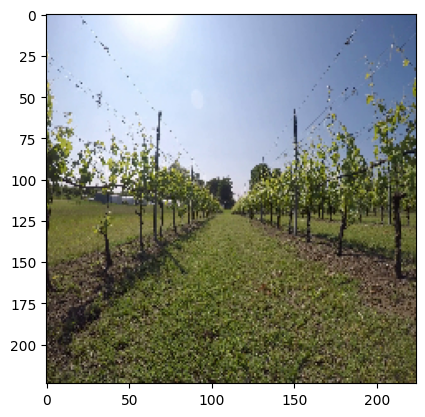

0.0 255.0


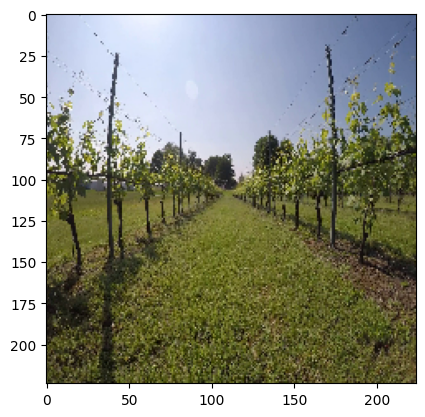

0.0 255.0


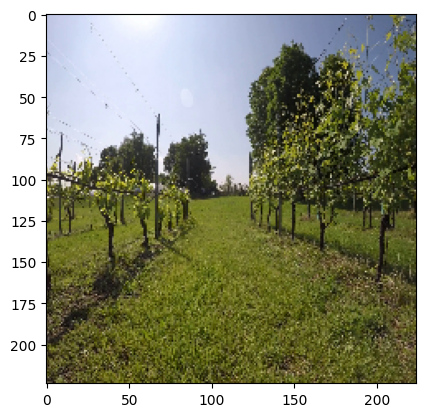

0.0 253.63385


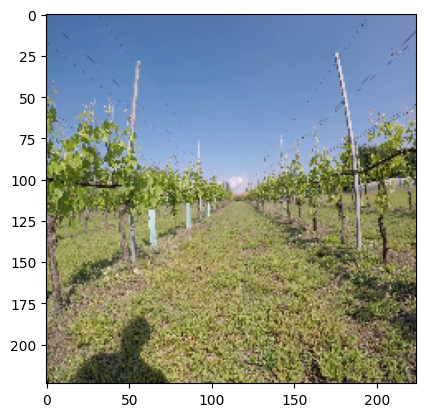

In [67]:
for i in img_ds:
    for n, j in enumerate(i):
        #print(j)
        print(np.min(j), np.max(j))
        plt.imshow(j/255.0)
        plt.show()
        if n >= 3:
            break
    break

0.0 255.0


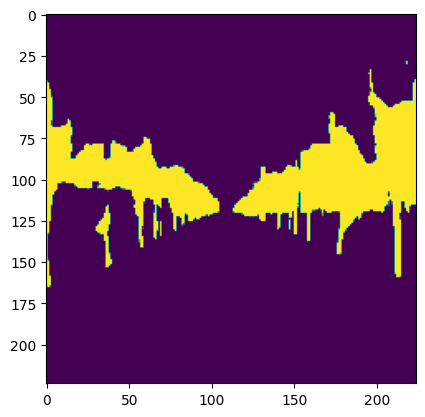

0.0 255.0


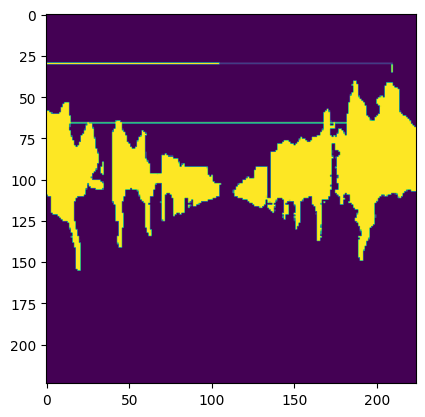

0.0 255.0


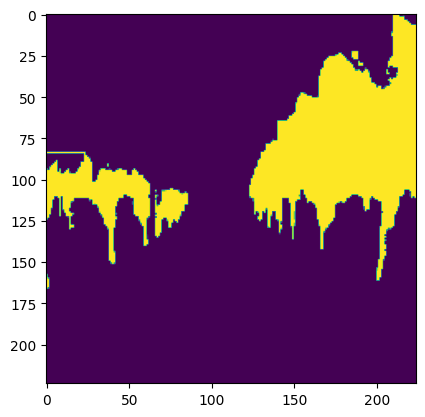

In [68]:
for i in mask_ds:
    for n, j in enumerate(i):
        #print(j)
        print(np.min(j), np.max(j))
        plt.imshow(j/255.0)
        plt.show()
        if n >= 2:
            break
    break

In [ ]:
ds1 = tf.data.Dataset.zip((img_ds, mask_ds))

In [ ]:
for i, (x, y) in enumerate(ds1):
    plt.imshow(x[0]/255.0, alpha=.8)
    plt.imshow(y[0]/255.0, alpha=.2)
    plt.show()
    
    x_, y_ = random_resize_crop(x[0], y[0], 0.7)
    print(x_.shape, y_.shape)
    
    plt.imshow(x_/255.0, alpha=.8)
    plt.imshow(y_/255.0, alpha=.2)
    plt.show()
    
    if i > 3:
        break

In [ ]:
np.mean(y_), np.std(y_)

In [ ]:
plt.hist(y_)

In [ ]:
y_ = y_/255.0

In [ ]:
np.mean(y_), np.std(y_)

In [ ]:
plt.hist(y_)

In [ ]:
y_ = tf.math.round(y_)

In [ ]:
np.mean(y_), np.std(y_)

In [ ]:
plt.hist(y_)

# Annotations

In [13]:
from pycocotools.coco import COCO
import os
from matplotlib import image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
from pathlib import Path

In [14]:
if not os.path.exists("masks"):
    os.makedirs("masks")
    
root = "../AgriSeg_Dataset/misc/misc_1/"
annFile = root + "annotations.json"
masks = root + "masks/"
images = root + "images/"

old = Path("../AgriSeg_Dataset/vineyard_real/vineyard_real_1/images/")

coco = COCO(annFile)

catIds = coco.getCatIds()
imgIds = coco.getImgIds()
annsIds = coco.getAnnIds()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
annsIds

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [17]:
%matplotlib inline

for aid in annsIds:
    if aid >= 500:
        break
    img = coco.loadImgs(aid)[0]
    print(img)
    
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    img_id = re.split(r'[/.]',img["file_name"])[-2]
    
    if anns:
        mask = np.zeros(coco.annToMask(anns[0]).shape) 
        for ann in anns:
            mask += coco.annToMask(ann)
    
        mask[mask >= 1] = 1
        image.imsave(masks + img_id + ".png", mask, cmap='gray')
    
        for i in list(old.rglob("*")):
            if str(i).endswith(f"{img_id}.jpg"):
                print(i)
                shutil.copyfile(i, images+f"{img_id}.jpg")

{'id': 0, 'file_name': 'images/image_15.jpg', 'width': 259, 'height': 194}
{'id': 1, 'file_name': 'images/image_29.jpg', 'width': 301, 'height': 168}
{'id': 2, 'file_name': 'images/image_28.jpg', 'width': 305, 'height': 165}
{'id': 3, 'file_name': 'images/image_14.jpg', 'width': 276, 'height': 183}
{'id': 4, 'file_name': 'images/image_16.jpg', 'width': 285, 'height': 177}
{'id': 5, 'file_name': 'images/image_17.jpg', 'width': 276, 'height': 183}
{'id': 6, 'file_name': 'images/image_13.jpg', 'width': 275, 'height': 183}
{'id': 7, 'file_name': 'images/image_12.jpg', 'width': 960, 'height': 540}
{'id': 8, 'file_name': 'images/image_38.jpg', 'width': 275, 'height': 183}
{'id': 9, 'file_name': 'images/image_10.jpg', 'width': 3467, 'height': 2536}
{'id': 10, 'file_name': 'images/image_11.jpg', 'width': 1600, 'height': 800}
{'id': 11, 'file_name': 'images/image_39.jpg', 'width': 275, 'height': 183}
{'id': 12, 'file_name': 'images/image_89.png', 'width': 625, 'height': 338}
{'id': 13, 'file_na

In [18]:
len(annsIds)

100

# Dataset Check

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Libraries
import os
import glob
import matplotlib.pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
from tqdm.notebook import tqdm as tqdm
import tensorflow as tf
import random
from pathlib import Path

from utils.tools import *
from utils.preprocess import *
from utils.visualize import *
from utils.data import *

2023-07-25 12:22:48.392202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 12:22:48.545445: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 12:22:48.607916: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-25 12:22:49.108663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", physical_devices)

#select the working GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-25 12:22:50.040438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 12:22:50.050333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 12:22:50.050418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# define some variables and read config
config_path = 'utils/config.yaml'
data_dir = Path('../AgriSeg_Dataset/')
model_dir = Path('bin')
logs_dir = Path('logs')
config = read_yaml(config_path)
config

{'GPU': [0],
 'SEED': 0,
 'VERBOSE': False,
 'NAME': 'ISW',
 'SAVE_BEST': True,
 'HP_SEARCH': False,
 'HP_SEARCH_NAME': 'kd_aug_rome',
 'HP_SEARCH_DIR': 'trials',
 'N_TRIALS': 12,
 'CITYSCAPES': False,
 'DG': True,
 'METHOD': 'ISW',
 'PADAIN': {'P': 0.001, 'EPS': '1e-5'},
 'UNISTYLE': True,
 'WHITEN_LAYERS': [-1, 0, 1],
 'TARGET': 'pear',
 'SOURCE': ['tree_2', 'chard', 'lettuce', 'vineyard'],
 'SUBSAMPLE': True,
 'STYLE_AUG': True,
 'RND_FLIP': 0.5,
 'RND_CROP': 0.5,
 'RND_GREY': 0.1,
 'RND_JITTER': 1.0,
 'RND_JITTER_RNG': 0.4,
 'DATA_PATH': 'datasets/',
 'MODEL_PATH': 'bin/',
 'LOG_PATH': 'logs/',
 'IMG_SIZE_TEST': [640, 480],
 'IMG_SIZE': 224,
 'SPLIT_SIZE': 0.1,
 'BATCH_SIZE': 64,
 'N_CLASSES': 1,
 'N_EPOCHS': 50,
 'LOSS': 'bce',
 'AUX_LOSS': False,
 'KD': {'ALPHA': 0.0001, 'T': 2},
 'CL': {'TEMP': 0.5, 'WEIGHT': 0.0},
 'OPTIMIZER': 'adamw',
 'SGD': {'LR': '1e-2', 'MOMENTUM': 0.8, 'DECAY': 0.1, 'NESTEROV': False},
 'ADAM': {'LR': '3e-4'},
 'ADAMW': {'LR': '5e-3', 'LR_END': '5e-6', '

In [5]:
config['SOURCE'] = ['pear']
config['TARGET'] = 'chard'

In [6]:
source_dataset = sorted([data_dir.joinpath(d) 
                         for d in config['SOURCE'] if d != config['TARGET']])
target_dataset = data_dir.joinpath(config['TARGET'])

ds_source, ds_target = load_multi_dataset(source_dataset, target_dataset, config)

../AgriSeg_Dataset/pear/pear_1
Found 1200 files belonging to 1 classes.


2023-07-25 12:23:05.509440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 12:23:05.510122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 12:23:05.510228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 12:23:05.510271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/pear/pear_2
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/pear/pear_3
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/pear/pear_4
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/chard/chard_1
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/chard/chard_2
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/chard/chard_3
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.
../AgriSeg_Dataset/chard/chard_4
Found 1200 files belonging to 1 classes.
Found 1200 files belonging to 1 classes.


In [7]:
len(ds_source[0])

4800

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 1)


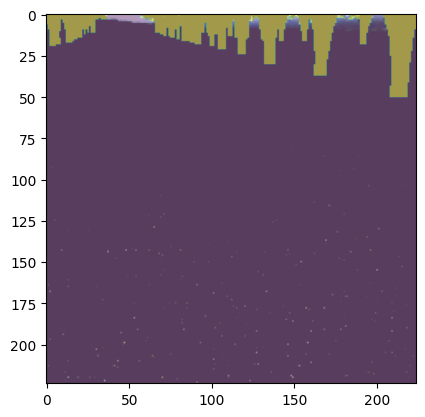

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 1)


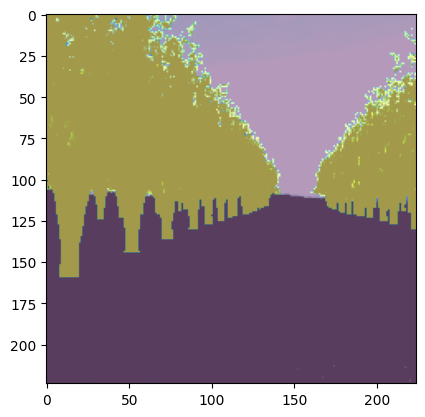

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 1)


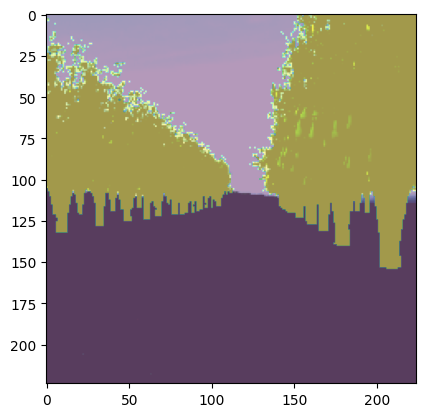

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 1)


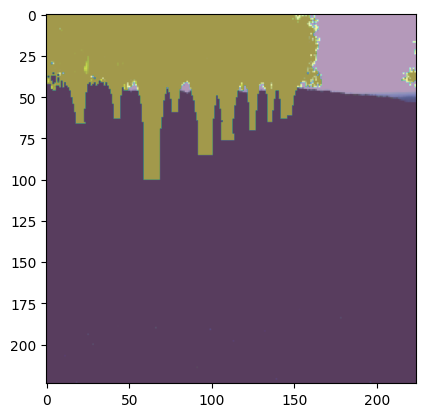

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3) (1, 224, 224, 1)


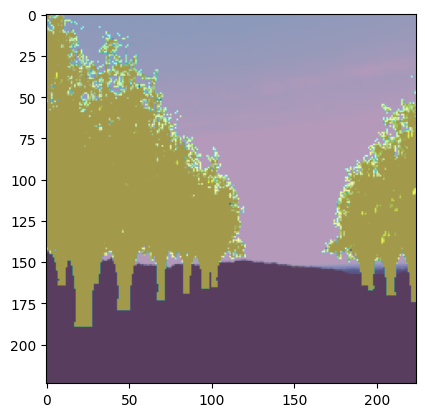

In [8]:
for i, (x, y) in enumerate(ds_source[0]):
    print(x.shape, y.shape)
    plt.imshow(x[0], alpha=.6)
    plt.imshow(y[0], alpha=.4)
    plt.show()
    if i > 3:
        break

# Old

In [ ]:
import os

count = 0
for root_dir, cur_dir, files in os.walk('datasets/dataset_albero/'):
    count += len(files)
print('file count:', count)

In [ ]:
count/4

In [ ]:
from PIL import Image

In [ ]:
i = np.array(Image.open('20191010_L4_S_1100.png'))

In [ ]:
i.min(), i.max(), i.mean()

In [ ]:
plt.imshow(i/2.0)

In [ ]:
Image.open('Agrivol_datasets/dataset_zucchini/zucchini_dataset1/masks/Image100/Segmentation0001.png')

In [ ]:
Image.open('Agrivol_datasets/dataset_lattuga/dataset_lattuga_4/images/Image100/Image0001.png')

In [ ]:
Image.open('Agrivol_datasets/dataset_pero/dataset_pero_4/images/Image100/Image0001.png')

In [ ]:
Image.open('Agrivol_datasets/dataset_zucchini/zucchini_dataset4/images/Image100/Image0001.png')

# PyTorch

In [1]:
import os
from pathlib import Path

import random
import torch
import torchvision.transforms as T
import PIL.Image as Image
import matplotlib.pyplot as plt

from utils.tools import read_yaml

2023-06-22 15:21:53.272732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 15:21:53.340355: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 15:21:53.357071: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-22 15:21:53.675251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
config_path = 'utils/config.yaml'
data_dir = Path('datasets')
model_dir = Path('bin')
logs_dir = Path('logs')
config = read_yaml(config_path)

In [44]:
class SemanticSegmentationDataset(torch.utils.data.Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, config, augment=False):
        self.root_dir = Path(root_dir)  
        self.config = config
        self.augment = augment
        self.images, self.masks = [], []
        
        self.get_file_lists()
        self.get_transforms()
        
    def get_file_lists(self):
        for subdir in self.root_dir.iterdir():
            if subdir.is_file() or subdir.name.startswith('.'): continue
            image_file_names = [list(f.glob('**/*'))[0].absolute() 
                                for f in subdir.joinpath('images').iterdir()]
            mask_file_names = [list(f.glob('**/*'))[0].absolute() 
                               for f in subdir.joinpath('masks').iterdir()]
            self.images += sorted(image_file_names)
            self.masks += sorted(mask_file_names)
        
    
    def get_transforms(self):
        if self.augment:
            self.image_transforms = T.Compose([
                T.RandomResizedCrop(self.config['IMG_SIZE'], 
                                    scale=(self.config['RND_CROP'], 1.0),
                                    interpolation=T.InterpolationMode.BILINEAR),
                T.RandomHorizontalFlip(self.config['RND_FLIP']),
                T.ColorJitter(brightness=self.config['RND_JITTER_RNG'],
                              contrast=self.config['RND_JITTER_RNG']),
                T.RandomGrayscale(config['RND_GREY']),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])
            
            self.mask_transforms = T.Compose([
                T.RandomResizedCrop(self.config['IMG_SIZE'], 
                                    scale=(self.config['RND_CROP'], 1.0),
                                    interpolation=T.InterpolationMode.NEAREST),
                T.RandomHorizontalFlip(self.config['RND_FLIP']),
                T.ToTensor(),
                T.Lambda(lambda mask: torch.where(mask > 0, 1.0, 0.0))
                
            ])
            
        else:
            self.image_transforms = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])
            
            self.mask_transforms = T.Compose([
                T.ToTensor(),
                T.Lambda(lambda mask: torch.where(mask > 0, 1.0, 0.0))
            ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx]).convert('L')
        
        self.seed = np.random.randint(2147483647) # make a seed with numpy generator 

        image = self.preprocess_image(image)
        mask = self.preprocess_mask(mask)
        return image, mask
    
    def preprocess_image(self, image):
        random.seed(self.seed) 
        torch.manual_seed(self.seed) 
        return self.image_transforms(image)
    
    def preprocess_mask(self, mask):
        random.seed(self.seed) 
        torch.manual_seed(self.seed) 
        return self.mask_transforms(mask)

In [51]:
ds = SemanticSegmentationDataset('datasets/vineyard_pergola/', config, augment=True)
len(ds)

4800

In [52]:
dl = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True, num_workers=24)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
tensor(0.) tensor(1.)


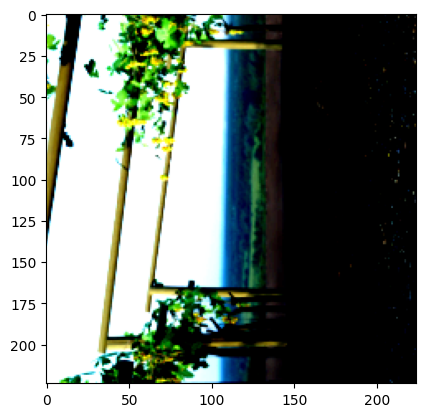

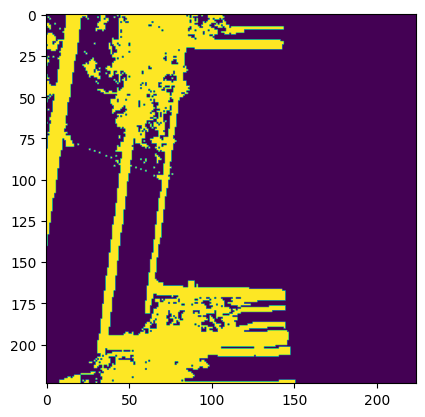

In [53]:
for i, m in dl:
    print(i.shape, m.shape)
    print(torch.min(m), torch.max(m))
    plt.imshow(torch.swapaxes(i[0], 0, -1))
    plt.show()
    plt.imshow(torch.swapaxes(m[0], 0, -1))
    break

In [16]:
a = Path('datasets/chard/chard_1/images/Image1/')

In [17]:
list(a.iterdir())

[PosixPath('datasets/chard/chard_1/images/Image1/Image0001.png')]